<a href="https://colab.research.google.com/github/markcastorm/COVID-19-Test-Results-Random-Forest-Classification/blob/main/COVID_19_Test_Results_Random_Forest_Classification_given_the_CarbonHealth_and_BraidHealth_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##COVID-19 Test Result Prediction - Random Forest Classification - Intro

This is an experiment, trying to predict COVID-19 PCR test results based on clinical and epidemiological data . The purpose of the experiment proposed here is only to demonstrate the potential of such a method and to analyze feasibility and predictibility. If this classification problem is preidctable, then one can think of "Virtual Tests", based on ML, that can assist in prioritizing the real
 tests.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot
from scipy import interp

from sklearn.metrics import auc

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import sklearn
print(sklearn.__version__)


1.3.0


In [ ]:
from sklearn.metrics import RocCurveDisplay

In [ ]:
# Set RSEED for stability of random actions
RSEED = 50

In [ ]:
df = pd.read_csv('coronavirusdataset.csv')

FileNotFoundError: ignored

In [ ]:
df.head()

,batch_date,test_name,swab_type,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,...,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_findings,cxr_impression,cxr_label,cxr_link
0,2020-10-20,"SARS-CoV-2, NAA",Nasal,Negative,39,False,NaN,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
1,2020-10-20,COVID-19 PCR External Result,Nasal,Negative,56,False,NaN,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
2,2020-10-20,Rapid COVID-19 PCR Test,Nasal,Negative,35,False,NaN,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
3,2020-10-20,Rapid COVID-19 PCR Test,Nasal,Negative,37,False,NaN,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN
4,2020-10-20,Rapid COVID-19 PCR Test,Nasal,Negative,42,False,NaN,False,False,False,...,False,False,False,False,False,False,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['batch_date', 'test_name', 'swab_type', 'covid19_test_results', 'age',
       'high_risk_exposure_occupation', 'high_risk_interactions', 'diabetes',
       'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'smoker',
       'temperature', 'pulse', 'sys', 'dia', 'rr', 'sats', 'rapid_flu_results',
       'rapid_strep_results', 'ctab', 'labored_respiration', 'rhonchi',
       'wheezes', 'days_since_symptom_onset', 'cough', 'cough_severity',
       'fever', 'sob', 'sob_severity', 'diarrhea', 'fatigue', 'headache',
       'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore',
       'sore_throat', 'cxr_findings', 'cxr_impression', 'cxr_label',
       'cxr_link'],
      dtype='object')

##Preprocessing

Here we will be doing some simple preprocesing and also one hot encoding, etc.

In [ ]:
#Preprocessing
columns_to_drop=['batch_date','cxr_findings','cxr_impression','cxr_link'] # We won't use these for our classification
columns_to_boolean=['high_risk_exposure_occupation','high_risk_interactions','ctab','labored_respiration','rhonchi','wheezes','cough','fever','sob','diarrhea','fatigue','headache','loss_of_smell','loss_of_taste','runny_nose','muscle_sore','sore_throat']
columns_to_ordinal = ['cough_severity','sob_severity'] # Mild, Moderate and Severe - we will transform them to numbers
columns_with_pos_neg = ['rapid_flu_results','rapid_strep_results']
target_column='covid19_test_results' #Prediction target variable
df=df.drop(columns_to_drop,axis=1)
df[columns_to_boolean]=df[columns_to_boolean].astype('boolean')
df=df.convert_dtypes()
bool_cols = list(df.select_dtypes(include=['bool']).columns)
df[bool_cols] = df[bool_cols].astype('float64') # we'll impute missing values so we want them as numbers
df[columns_to_ordinal]=df[columns_to_ordinal].replace('Moderate','1')
df[columns_to_ordinal]=df[columns_to_ordinal].replace('Mild','2')
df[columns_to_ordinal]=df[columns_to_ordinal].replace('Severe','3')
for col_name in columns_to_ordinal:
  df[col_name]=pd.to_numeric(df[col_name], errors='coerce')
df[columns_with_pos_neg]=df[columns_with_pos_neg].replace('Negative','0')
df[columns_with_pos_neg]=df[columns_with_pos_neg].replace('Positive','1')
for col_name in columns_with_pos_neg:
  df[col_name]=pd.to_numeric(df[col_name], errors='coerce')
df[target_column]=df[target_column].replace('Negative','0')
df[target_column]=df[target_column].replace('Positive','1')
df[target_column]=pd.to_numeric(df[target_column], errors='coerce')
df = df[df[target_column].notnull()] # drop records if covid-19 result is missing
cat_cols = list(df.select_dtypes(include=['string']).columns)
df[cat_cols] = df[cat_cols].astype('category')
df=pd.get_dummies(df) # One hot encoding
integer_cols = list(df.select_dtypes(include=['Int64', 'uint8']).columns)
df[integer_cols] = df[integer_cols].astype('float64')

In [ ]:
# OK, now we have a dataset, let's call it what it is
dataset = df
dataset_labels = np.array(dataset[target_column])

In [ ]:
# Dataset basic statistics
dataset.describe(include='all')

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,...,test_name_SARS COV2 NAAT,"test_name_SARS-CoV-2 (COVID-19) by NAAT/RT-PCR/TMA, Unknown Risk","test_name_SARS-CoV-2, NAA",swab_type_Mid Turbinate,swab_type_Nasal,swab_type_Nasopharyngeal,swab_type_Oropharyngeal,swab_type_Saliva,cxr_label_Negative,cxr_label_Significant
count,7294.000000,7294.000000,7294.00000,2727.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,...,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000,7294.000000
mean,0.003427,39.717576,0.02975,0.200220,0.001234,0.001508,0.032218,0.000685,0.007678,0.000274,...,0.018234,0.022210,0.403894,0.026049,0.955854,0.009323,0.008637,0.000137,0.000685,0.000274
std,0.058448,14.014773,0.16991,0.400238,0.035108,0.038807,0.176591,0.026175,0.087291,0.016558,...,0.133806,0.147376,0.490710,0.159291,0.205433,0.096110,0.092541,0.011709,0.026175,0.016558
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,30.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,38.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,50.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,87.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Let's check the types:
dataset.dtypes # Everything should be float64 so we can directly fit models

covid19_test_results                                                float64
age                                                                 float64
high_risk_exposure_occupation                                       float64
high_risk_interactions                                              float64
diabetes                                                            float64
chd                                                                 float64
htn                                                                 float64
cancer                                                              float64
asthma                                                              float64
copd                                                                float64
autoimmune_dis                                                      float64
smoker                                                              float64
temperature                                                         Float64
pulse       

##Data Exploration

Here we'll first explore the dataset as it is - using histograms, missing values, correlations.
Thereby our main goal here is to see that we have data that we can work with

array([[<Axes: title={'center': 'covid19_test_results'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'high_risk_exposure_occupation'}>,
        <Axes: title={'center': 'high_risk_interactions'}>,
        <Axes: title={'center': 'diabetes'}>,
        <Axes: title={'center': 'chd'}>, <Axes: title={'center': 'htn'}>],
       [<Axes: title={'center': 'cancer'}>,
        <Axes: title={'center': 'asthma'}>,
        <Axes: title={'center': 'copd'}>,
        <Axes: title={'center': 'autoimmune_dis'}>,
        <Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'pulse'}>],
       [<Axes: title={'center': 'sys'}>, <Axes: title={'center': 'dia'}>,
        <Axes: title={'center': 'rr'}>, <Axes: title={'center': 'sats'}>,
        <Axes: title={'center': 'rapid_flu_results'}>,
        <Axes: title={'center': 'rapid_strep_results'}>,
        <Axes: title={'center': 'ctab'}>],
       [<Axes: title={'center':

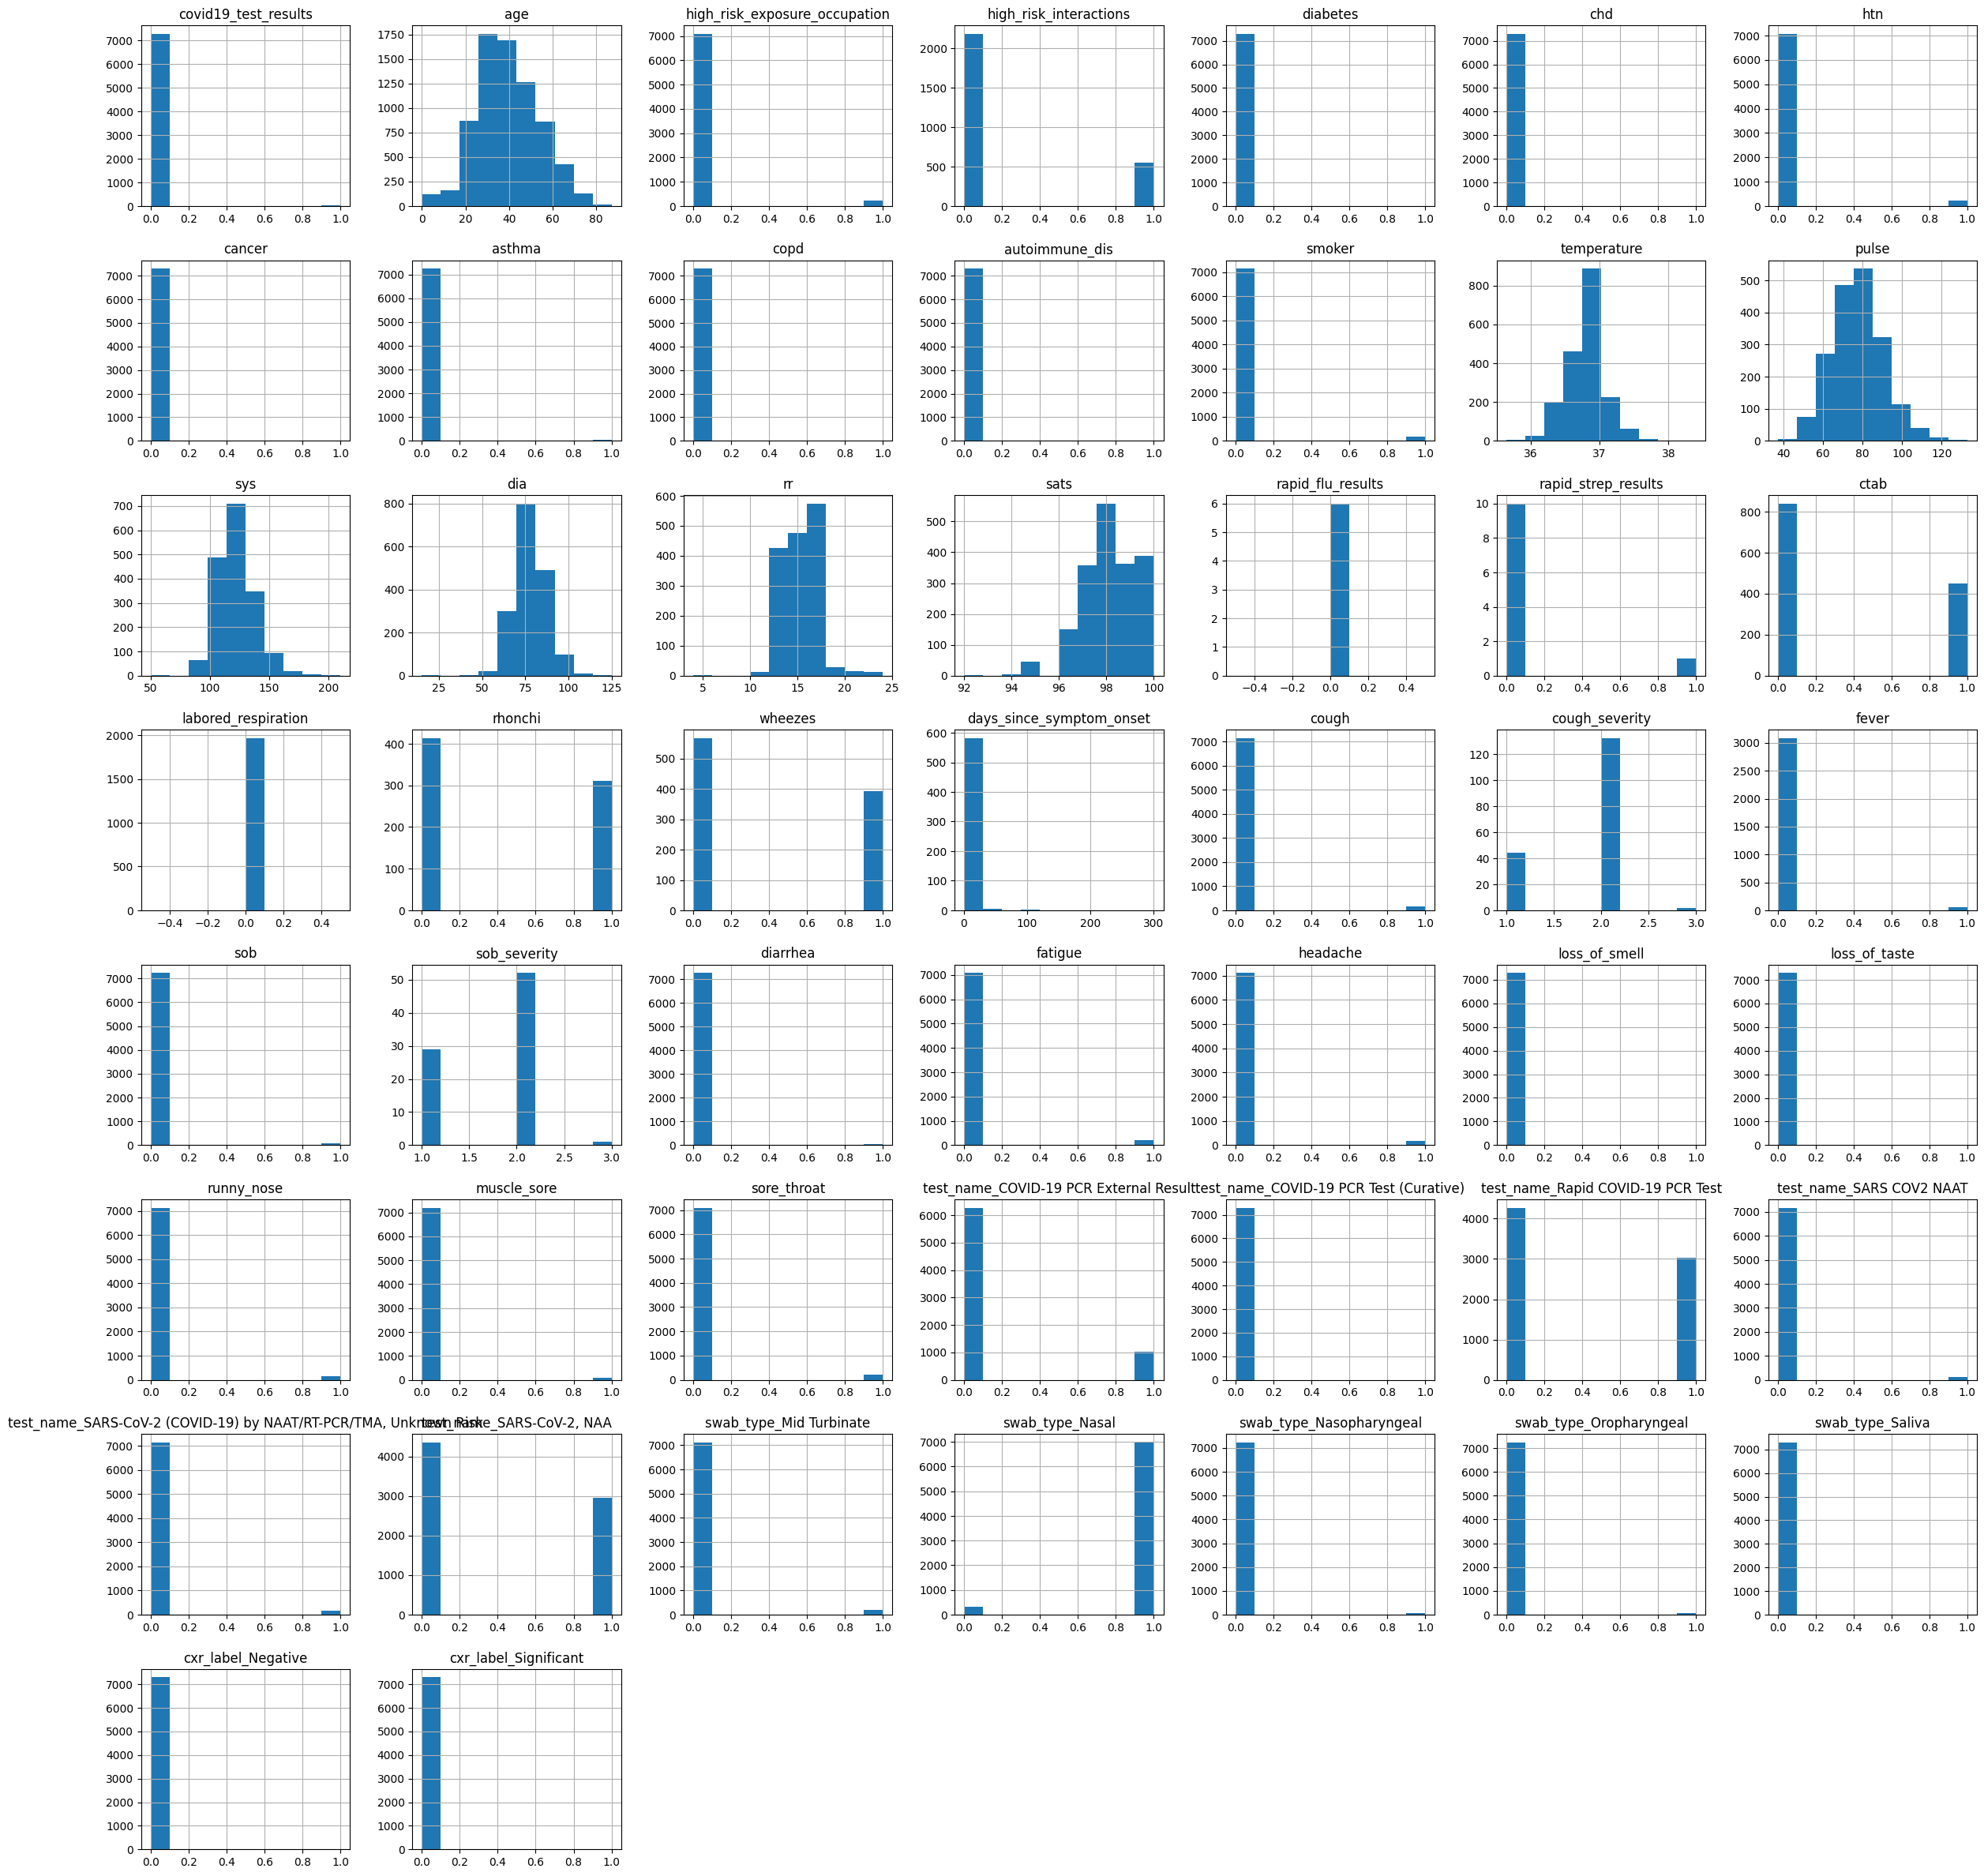

In [ ]:
df.hist(figsize=(30, 30))

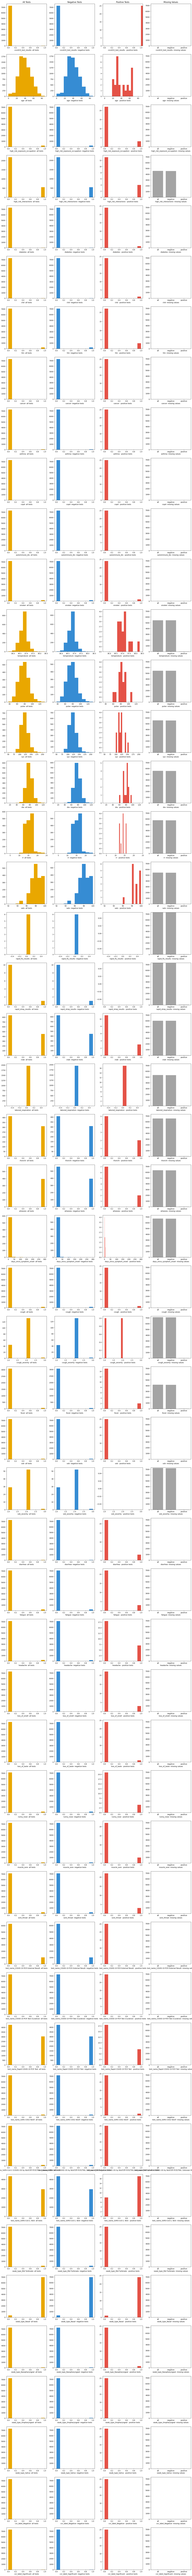

In [ ]:

neg_color =  '#368CD3'  # for tests with actual negative results
pos_color = '#E45247' # for tests with actual positive results
missing_color = '#A4A4A4' # for missing values
neutral_color = '#E9A700' # just a color
test_color = '#F5793A' # for test set color coding
train_color = '#A95AA1' # for training set color coding
chance_color = '#85C0F9' # coin flip color

fig=plt.figure(figsize=(20, 280))
cols = list(dataset.columns)
num_of_cols = len(cols)
num_of_samples = len(dataset)
i = 1
for iter in cols:
  plt.subplot(num_of_cols, 4, i)
  plt.hist(dataset[iter].dropna(),color=neutral_color)
  left, right = plt.xlim()
  plt.xlabel(iter+"- all tests")
  if i==1:
    plt.title("All Tests")
  plt.subplot(num_of_cols, 4, i+1)
  try:
    plt.hist(dataset[dataset[target_column]==0][iter].dropna(),color=neg_color)
    plt.xlim(left, right)
  except:
    print("nothing to plot in ", iter)
  plt.xlabel(iter+"- negative tests")
  if i==1:
    plt.title("Negative Tests")

  plt.subplot(num_of_cols, 4, i+2)
  try:
    plt.hist(dataset[dataset[target_column]==1][iter].dropna(),color=pos_color)
    plt.xlim(left,right)
  except:
    print("nothing to plot in ", iter)
  plt.xlabel(iter + " - positive tests")
  if i==1:
    plt.title("Positive Tests")
  plt.subplot(num_of_cols, 4, i+3)
  x = np.arange(3)
  missing_tot = dataset[iter].isna().sum()
  missing_neg = dataset[dataset[target_column]==0][iter].isna().sum()
  missing_pos = dataset[dataset[target_column]==1][iter].isna().sum()
  missing_values = [missing_tot, missing_neg, missing_pos]

  plt.bar(x,missing_values,color=missing_color)
  plt.xticks(x, ('all', 'negative', 'positive'))
  plt.xlabel(iter + "- missing values")
  plt.ylim(0, num_of_samples)

  if i==1:
    plt.title("Missing Values")
  i = i+4

In [ ]:
df.isnull().sum()

covid19_test_results                                                   0
age                                                                    0
high_risk_exposure_occupation                                          0
high_risk_interactions                                              4567
diabetes                                                               0
chd                                                                    0
htn                                                                    0
cancer                                                                 0
asthma                                                                 0
copd                                                                   0
autoimmune_dis                                                         0
smoker                                                                 0
temperature                                                         5425
pulse                                              

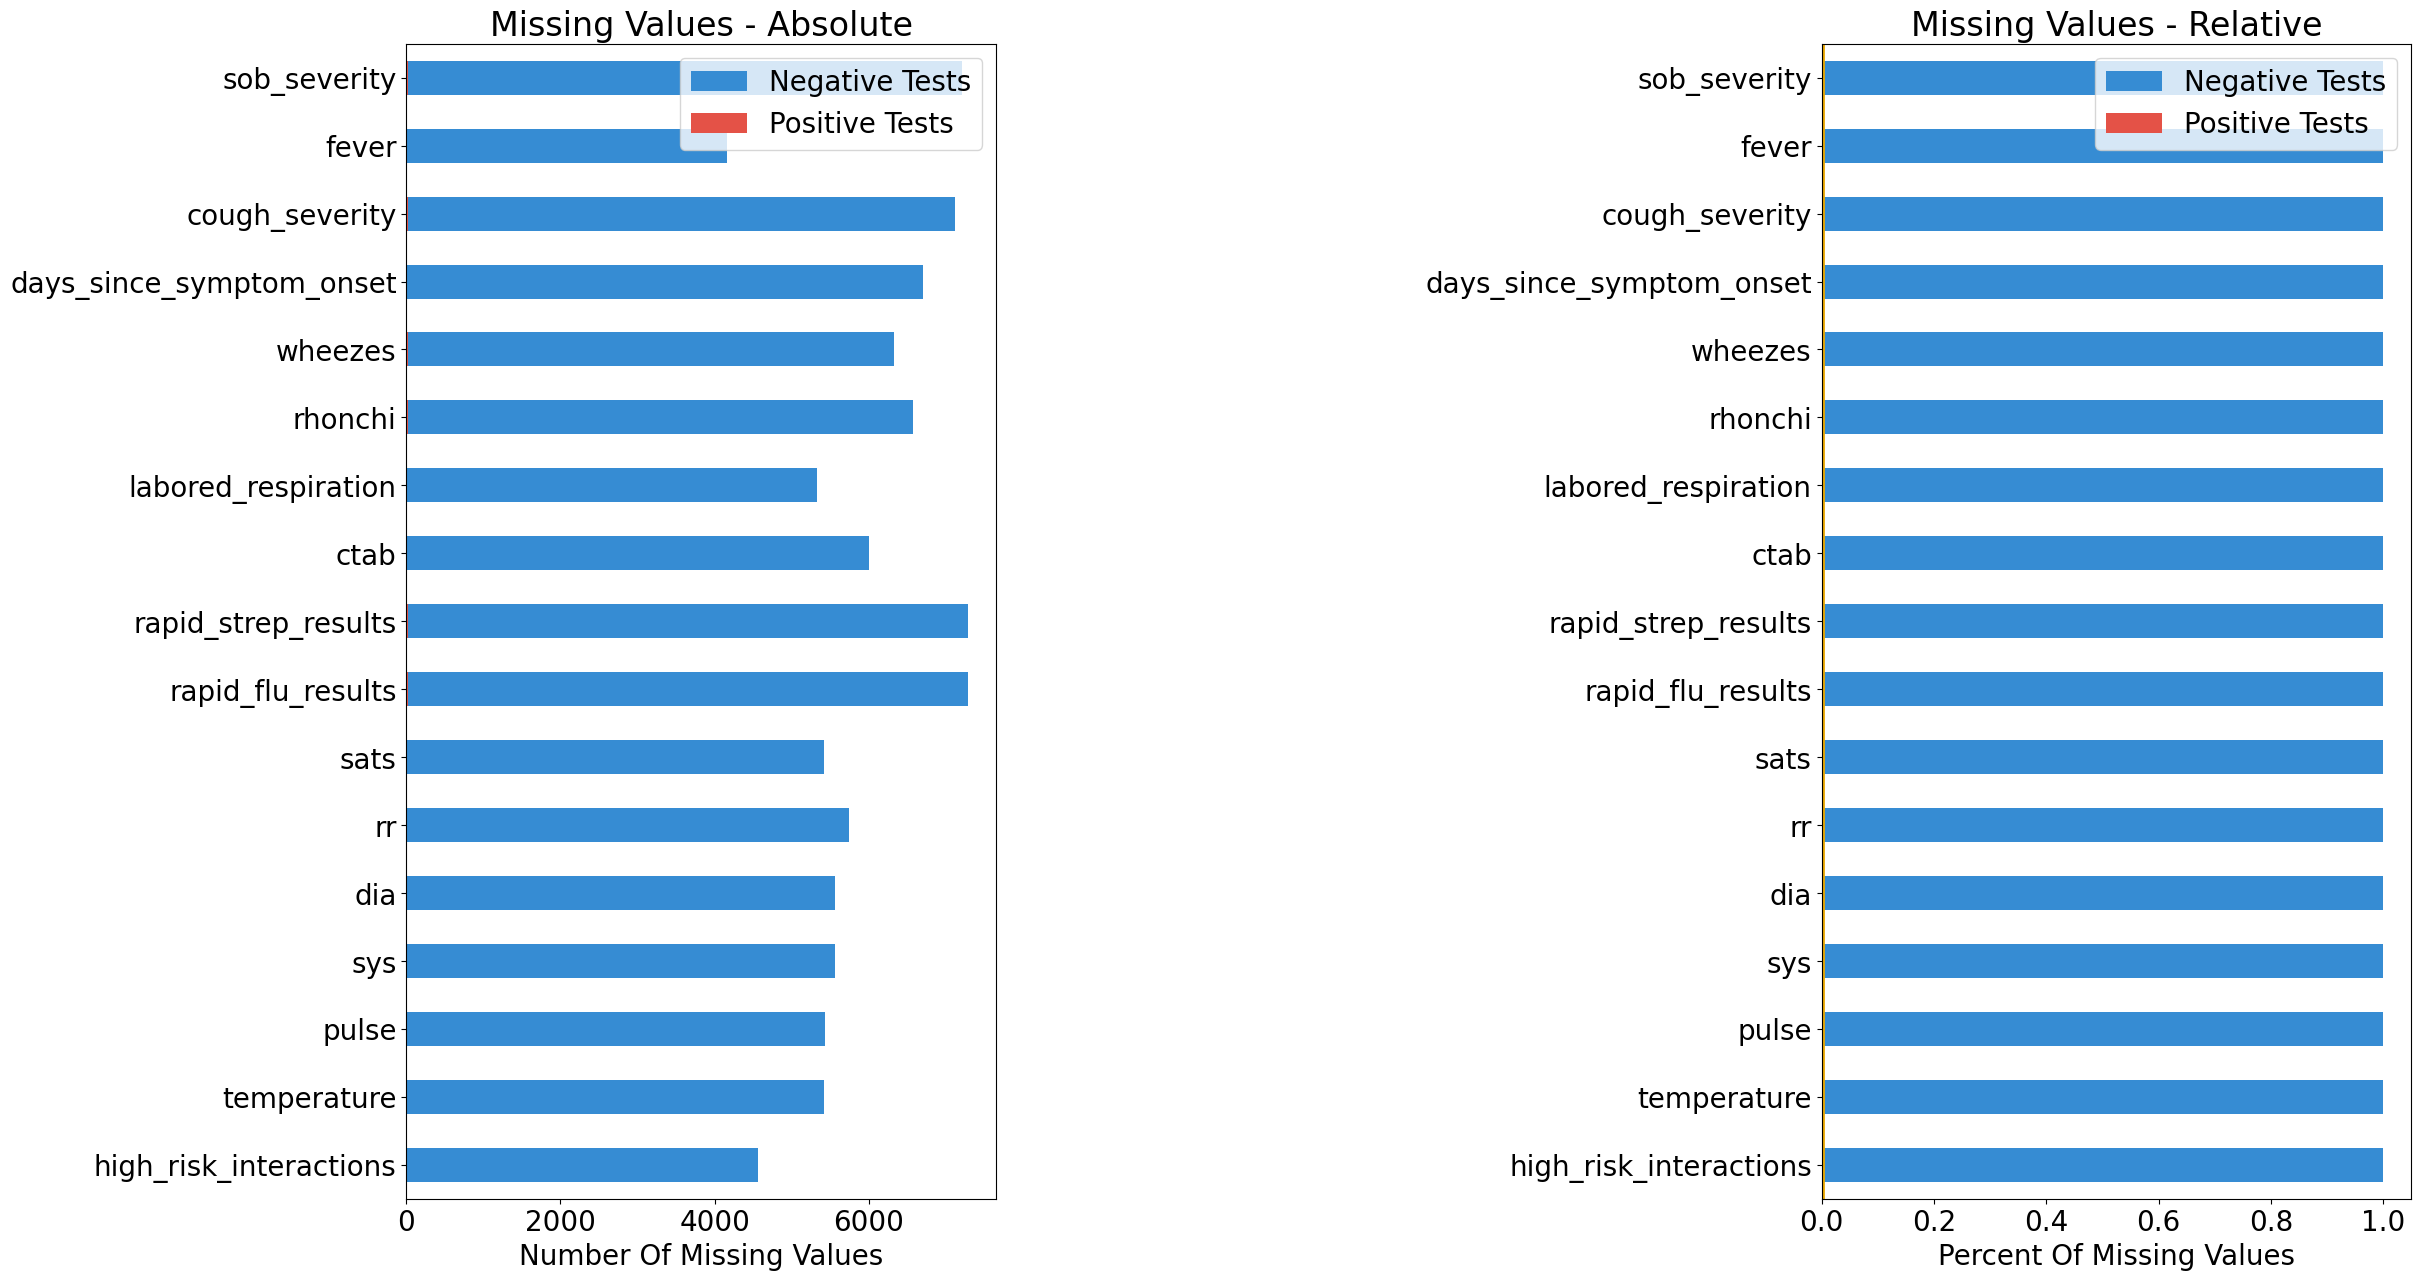

positive tests are 0.34% of all tests (vertical orange line, the chart on the right)
positive tests are 99.66% of all tests (vertical orange line, the chart on the right)


In [ ]:
# Missing Values Analysis
# Let's plot missing values - absolute and relative
fig=plt.figure(figsize=(35, 15))
plt.rcParams['font.size'] = 20

plt.subplot(1,4,1)
dataset.isnull().sum()[dataset.isnull().sum()>0].plot(kind='barh',color=neg_color)
dataset[dataset.covid19_test_results==1].isnull().sum()[dataset[dataset.covid19_test_results==1].isnull().sum()>0].plot(kind='barh',color=pos_color)
plt.legend(["Negative Tests","Positive Tests"],loc='upper right')
plt.title("Missing Values - Absolute")
plt.xlabel("Number Of Missing Values")

plt.subplot(1,4,3)
(dataset.isnull().sum()[dataset.isnull().sum()>0]/dataset.isnull().sum()[dataset.isnull().sum()>0]).plot(kind='barh',color=neg_color)
(dataset[dataset.covid19_test_results==1].isnull().sum()[dataset[dataset.covid19_test_results==1].isnull().sum()>0]/dataset.isnull().sum()[dataset.isnull().sum()>0]).plot(kind='barh',color=pos_color)
plt.legend(["Negative Tests","Positive Tests"],loc='upper right')
plt.title("Missing Values - Relative")
plt.xlabel("Percent Of Missing Values")
plt.axvline(x=len(dataset[dataset.covid19_test_results==1])/len(dataset),linewidth=2,color=neutral_color)

plt.show()
print ("positive tests are " + "{:.2%}".format(len(dataset[dataset.covid19_test_results==1])/len(dataset)) )
print ("Negative tests are " + "{:.2%}".format(len(dataset[dataset.covid19_test_results==0])/len(dataset)) )

Missing Values Imputation and Feature Engineering

We will fill missing values in .

In [ ]:
# Imputation of missing values:
# Here the Ordinal values - we'll impute with 0 - because coug/sob severity are only documented when cough/sob flag is TRUE
for iter in columns_to_ordinal:
  dataset[iter] = dataset[iter].fillna(0)

# All other values - we'll impute with averages:
dataset = dataset.fillna(dataset.mean())

In [ ]:
dataset = dataset.fillna(0.5)

In [ ]:
dataset.isnull().sum()

covid19_test_results                                                0
age                                                                 0
high_risk_exposure_occupation                                       0
high_risk_interactions                                              0
diabetes                                                            0
chd                                                                 0
htn                                                                 0
cancer                                                              0
asthma                                                              0
copd                                                                0
autoimmune_dis                                                      0
smoker                                                              0
temperature                                                         0
pulse                                                               0
sys                 

In [ ]:

dataset["number_of_symptoms"] = dataset['ctab'] + dataset['labored_respiration'] + dataset['rhonchi'] + dataset['wheezes'] + dataset['cough']+ dataset['fever'] \
  + dataset['sob']+dataset['diarrhea'] +dataset['fatigue'] + dataset['headache']	+ dataset['loss_of_smell']+ dataset['loss_of_taste'] + dataset['runny_nose'] + dataset['muscle_sore'] + dataset['sore_throat']
  # Consider adding cough_severity	and sob_severity
dataset["number_of_comorbidities"] = dataset["diabetes"] + dataset["chd"] + dataset["htn"] + dataset["cancer"] + dataset["asthma"] + dataset["copd"] + dataset["autoimmune_dis"]
dataset["number_of_epidmio_factors"] = dataset["high_risk_exposure_occupation"] + dataset["high_risk_interactions"]
dataset["vitals_multiplication"] = (dataset["temperature"] * dataset["pulse"] * dataset["sys"] * dataset["dia"] * dataset["rr"] * dataset["sats"])/(10**9) #TODO: replace this 10**9 magic number with something meaninfgul
dataset["vitals_multiplication_without_temp"] = (dataset["pulse"] * dataset["sys"] * dataset["dia"] * dataset["rr"] * dataset["sats"])/(10**8) #TODO: replace  this 10**8 magic number with something meaninfgul
dataset["vitals_multiplication_with_age"] = (dataset["vitals_multiplication"] * dataset["age"])/50
dataset["vitals_sum"] = (dataset["temperature"] + dataset["pulse"] + dataset["sys"] + dataset["dia"] + dataset["rr"] + dataset["sats"])/6
dataset["vitals_sum_with_age"] = (dataset["vitals_sum"] + dataset["age"])*(6/7)

##Modeling - Hyper Parameters

In [ ]:
rf_params = {
    'random_state':RSEED,
    'bootstrap': True,
    'max_depth': 3, # This will keep our trees simple
    'max_features': 10,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'n_estimators': 100, # Many estimators = better generalization
    'min_weight_fraction_leaf': 0.01, # This keeps our model from memorizing the training set
    'min_impurity_decrease': 0.001, # This keeps our model from memorizing the training set
    'class_weight':'balanced', # Our dataset is imbalanced so we'll balance while training
    'criterion':'gini'
    }

In [ ]:
labels = dataset.pop(target_column)
features = list(dataset.columns)

Modeling - Cross Validation

We'll train a random forest using cross validation method.

In [ ]:
X = np.array(dataset)
y = np.array(labels)

<ipython-input-39-37628263c454>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr_test = interp(mean_fpr_test, viz_test.fpr, viz_test.tpr)
<ipython-input-39-37628263c454>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr_train = interp(mean_fpr_train, viz_train.fpr, viz_train.tpr)
<ipython-input-39-37628263c454>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr_test = interp(mean_fpr_test, viz_test.fpr, viz_test.tpr)
<ipython-input-39-37628263c454>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr_train = interp(mean_fpr_train, viz_train.fpr, viz_train.tpr)
<ipython-input-39-37628263c454>:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp 

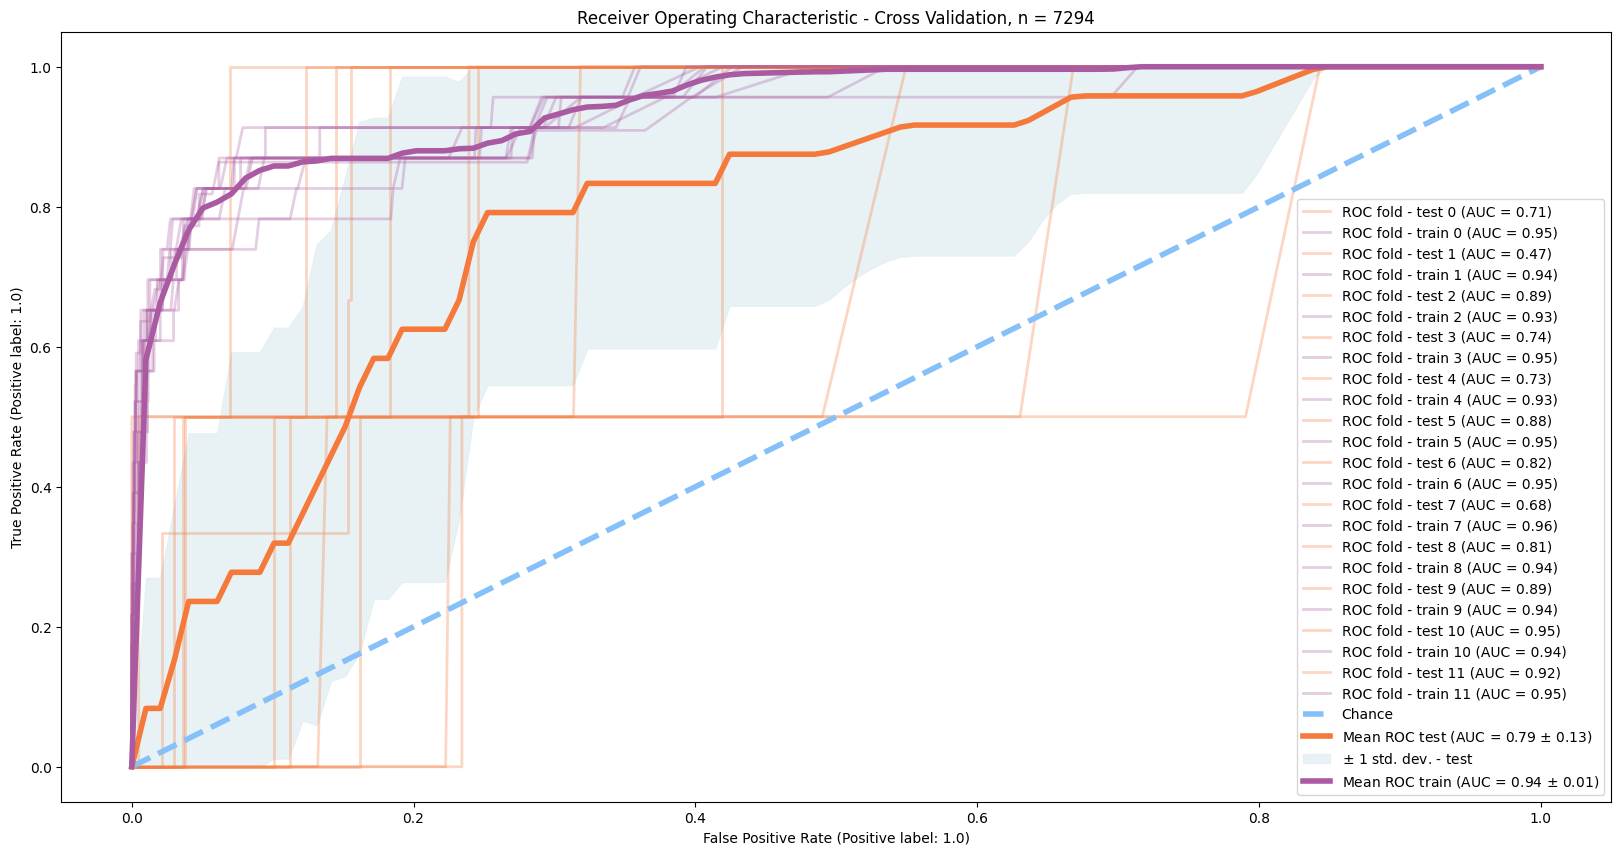

<Figure size 2000x1000 with 0 Axes>

In [ ]:
number_of_folds = 12
cv = StratifiedKFold(n_splits=number_of_folds, random_state=RSEED, shuffle=True)
classifier = RandomForestClassifier(**rf_params)

tprs_test = []
aucs_test = []
mean_fpr_test = np.linspace(0, 1, 100)
mean_fpr_train = np.linspace(0, 1, 100)
tprs_train = []
aucs_train = []
mean_fpr_train = np.linspace(0, 1, 100)
mean_fpr_train = np.linspace(0, 1, 100)
importances_all = np.zeros(len(features))

fig, ax = plt.subplots(figsize = (20, 10))
plt.rcParams['font.size'] = 10

for i, (train_fold, test_fold) in enumerate(cv.split(X, y)):
    classifier.fit(X[train_fold], y[train_fold])
    viz_test = RocCurveDisplay.from_estimator(classifier, X[test_fold], y[test_fold],
                         name='ROC fold - test {}'.format(i),
                         alpha=0.3, lw=2, ax=ax, color=test_color)
    viz_train = RocCurveDisplay.from_estimator(classifier, X[train_fold], y[train_fold],
                         name='ROC fold - train {}'.format(i),
                         alpha=0.3, lw=2, ax=ax, color=train_color)

    interp_tpr_test = interp(mean_fpr_test, viz_test.fpr, viz_test.tpr)
    interp_tpr_test[0] = 0.0
    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test.roc_auc)

    interp_tpr_train = interp(mean_fpr_train, viz_train.fpr, viz_train.tpr)
    interp_tpr_train[0] = 0.0
    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train.roc_auc)
    importances_all = importances_all + classifier.feature_importances_

ax.plot([0, 1], [0, 1], linestyle='--', lw=4, color=chance_color,
        label='Chance')#, alpha=.8)

mean_tpr_test = np.mean(tprs_test, axis=0)
mean_tpr_test[-1] = 1.0
mean_auc_test = auc(mean_fpr_test, mean_tpr_test)
std_auc_test = np.std(aucs_test)
ax.plot(mean_fpr_test, mean_tpr_test, color=test_color,
        label=r'Mean ROC test (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_test, std_auc_test),
        lw=4)#, alpha=.8)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr_test, tprs_lower_test, tprs_upper_test, color='#E3EFF3', alpha=.8,
                label=r'$\pm$ 1 std. dev. - test')


mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr_train, mean_tpr_train)
std_auc_train = np.std(aucs_train)
plt.figure(figsize = (20, 10))

ax.plot(mean_fpr_train, mean_tpr_train, color=train_color,
        label=r'Mean ROC train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),
        lw=4)#, alpha=.8)


ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic - Cross Validation, n = %0.0f" % len(X))
ax.legend(loc="lower right")
plt.show()

#Normalize importances
importances_all = importances_all/(number_of_folds+1)

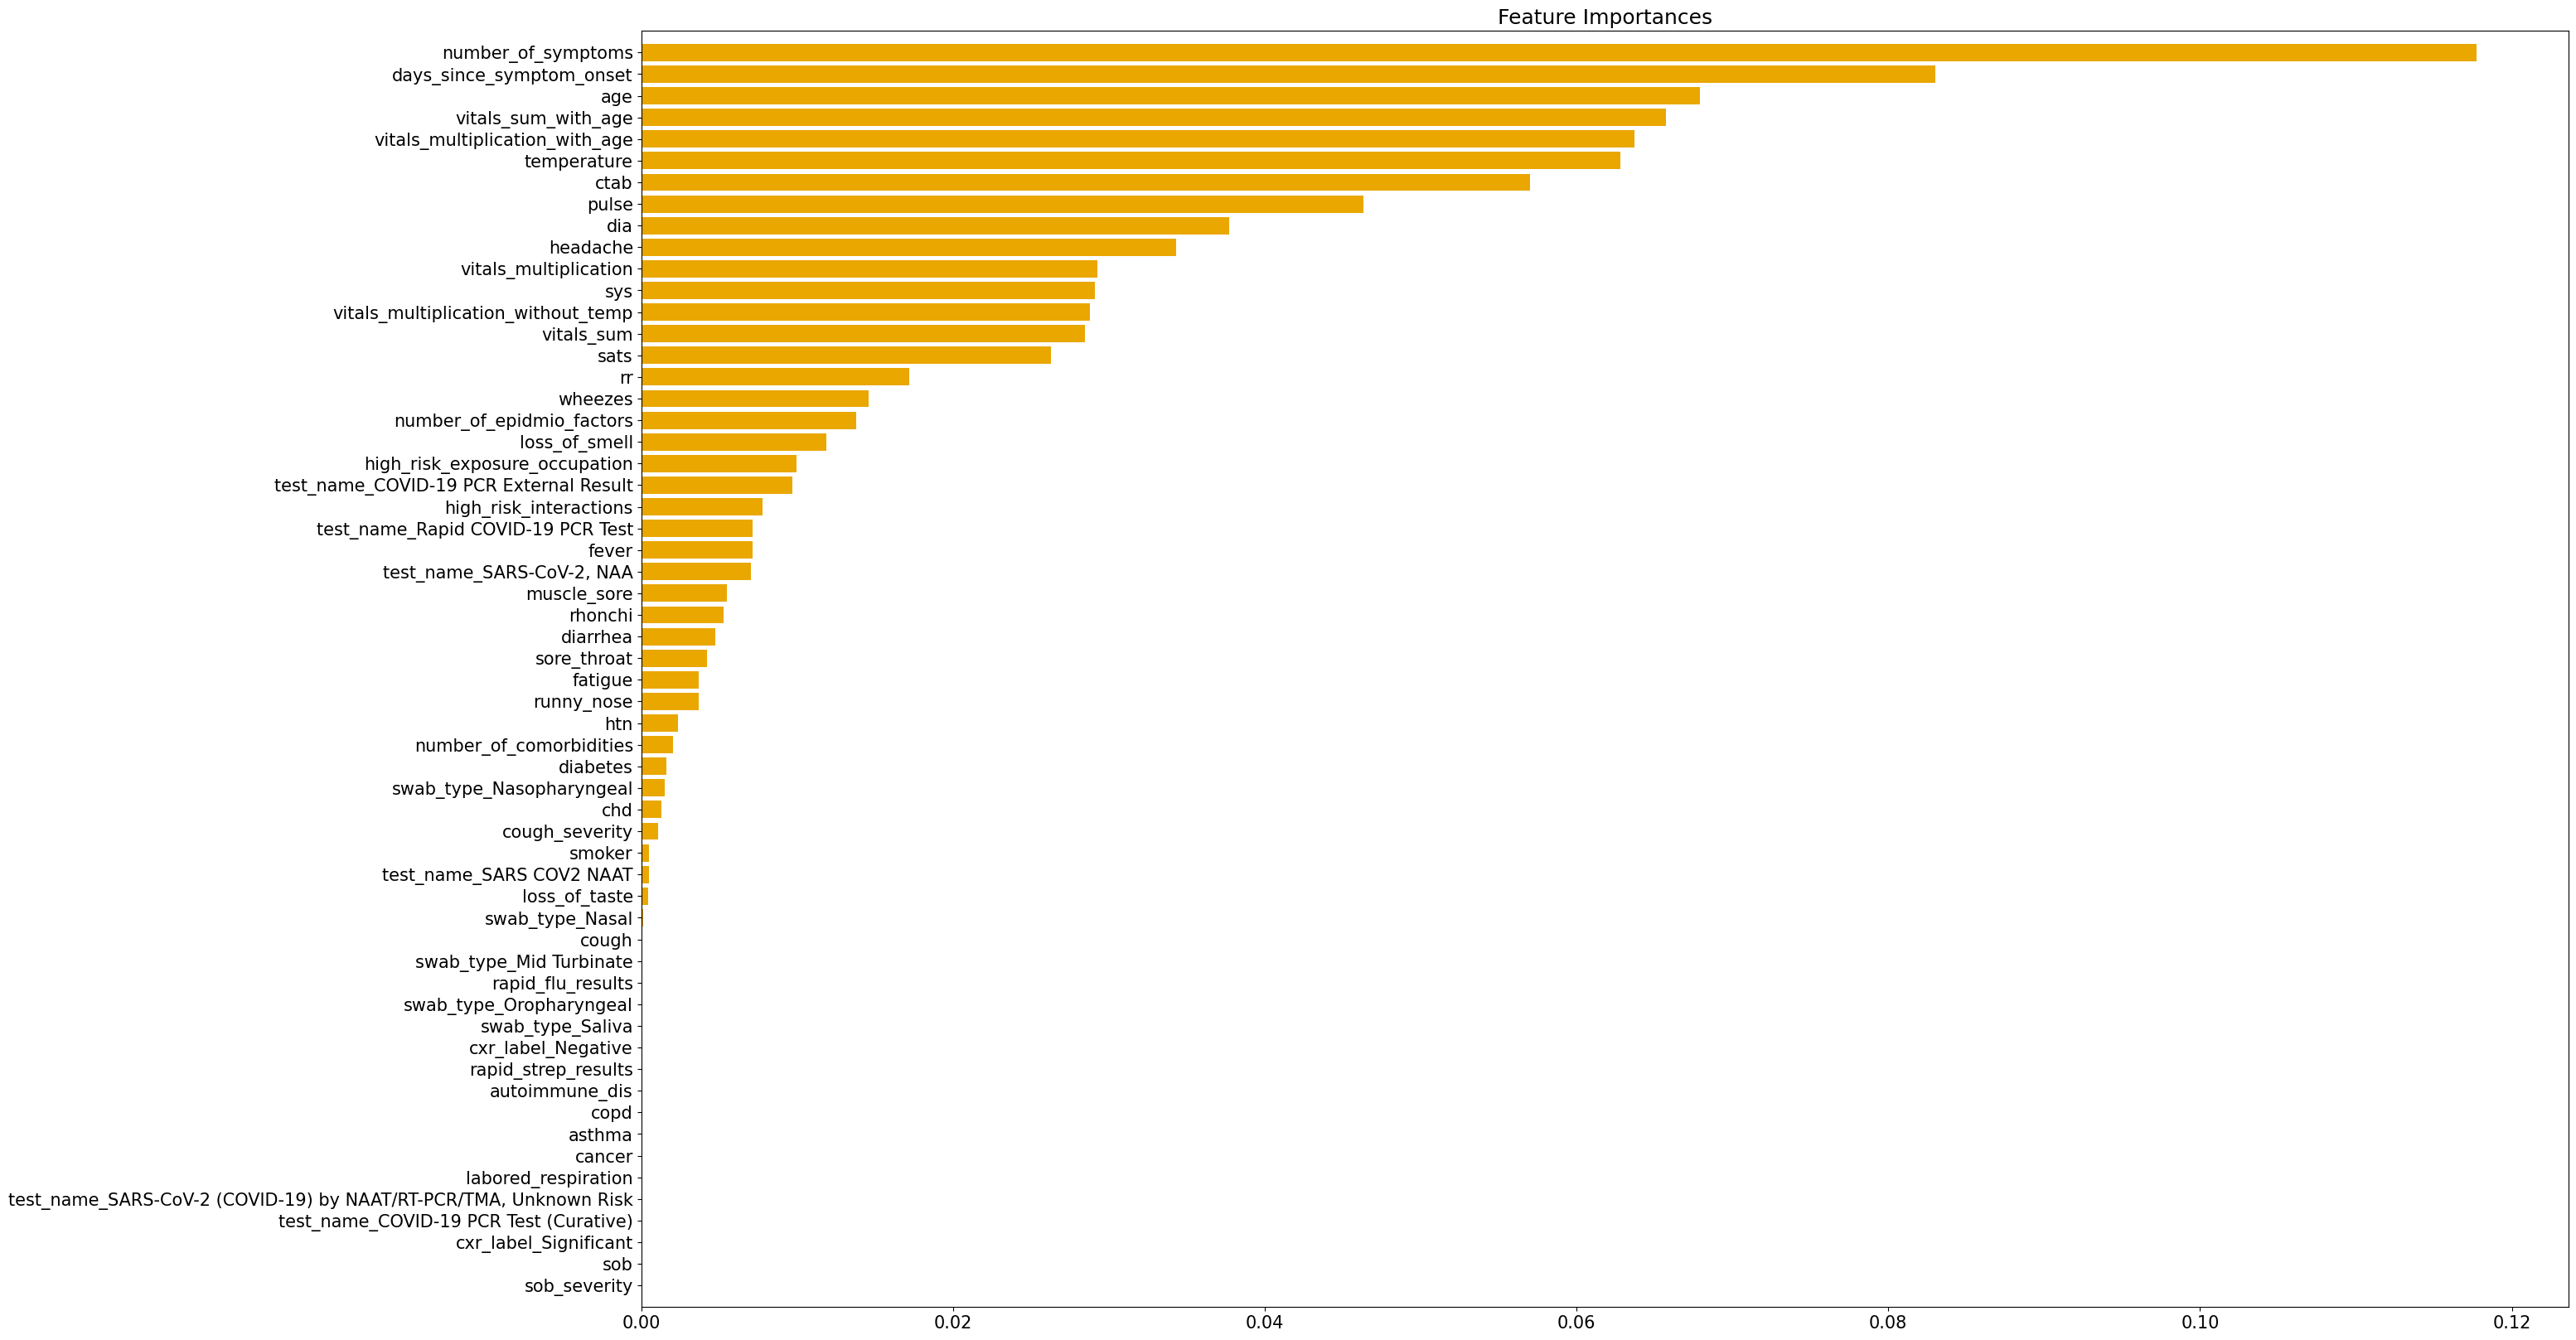

In [ ]:
#Analyze feature importance
importances = importances_all
indices = np.flip(np.argsort(importances)[::-1])
#std = np.std([tree.feature_importances_ for tree in model.estimators_],
#             axis=0)
plt.figure(figsize = (30, 20))
plt.rcParams['font.size'] = 15

plt.title("Feature Importances")
plt.barh(range(len(features)), importances[indices],
         color=neutral_color) #"#511E78")#, yerr=std[indices], align="center")
plt.yticks(np.arange(len(features)), np.array(features)[indices])
plt.ylim([-1, len(features)])

plt.show()

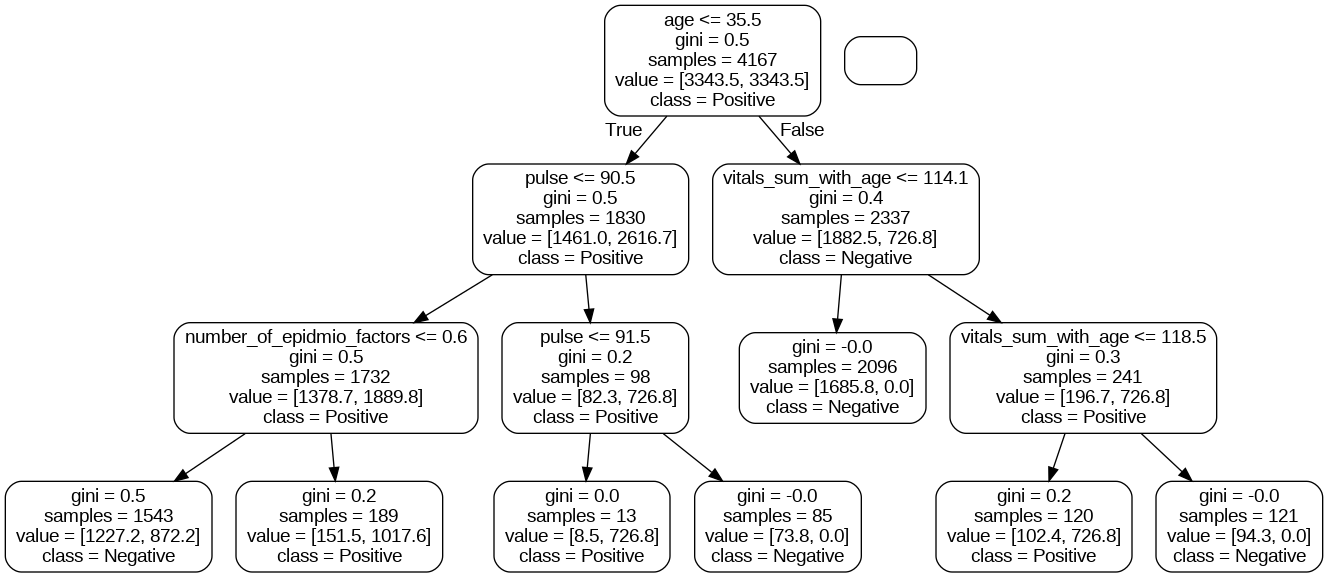

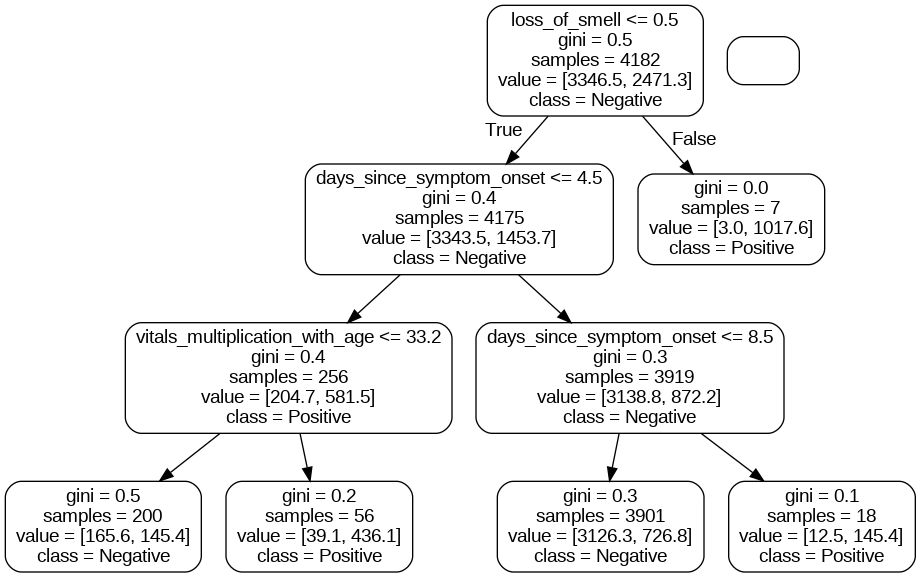

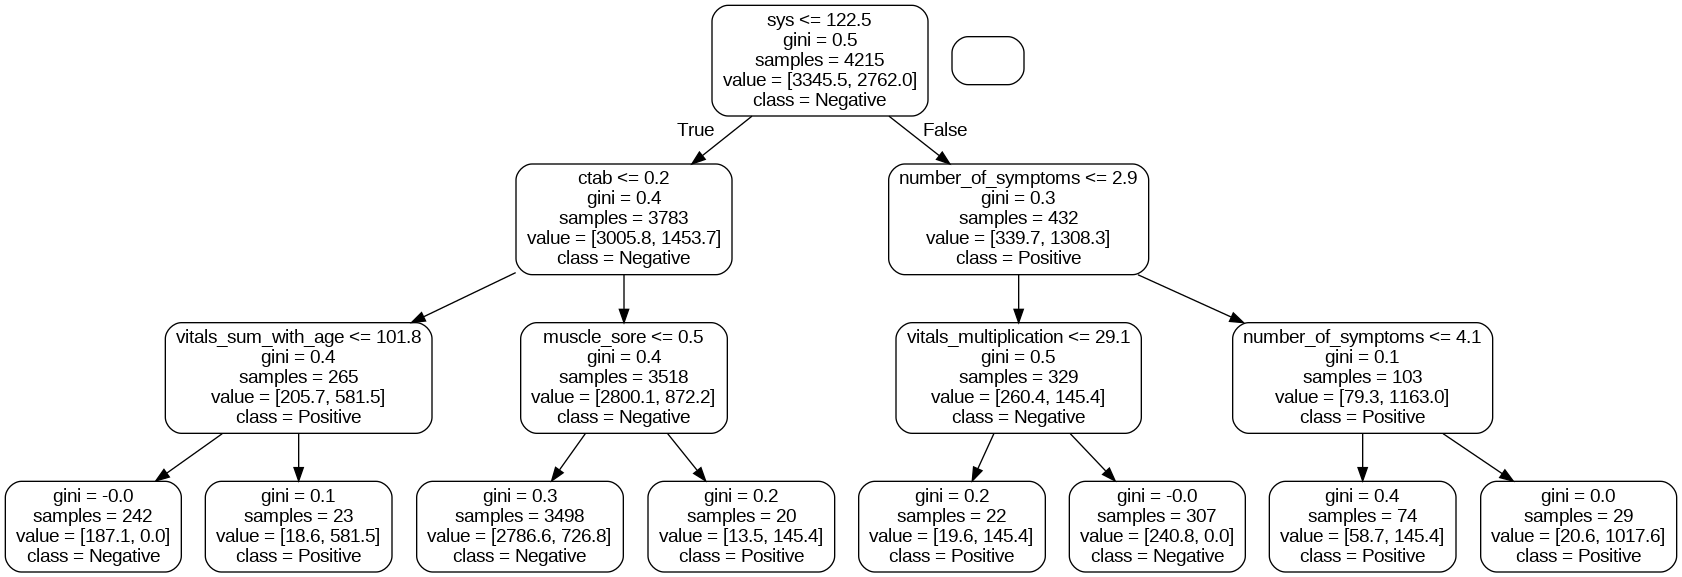

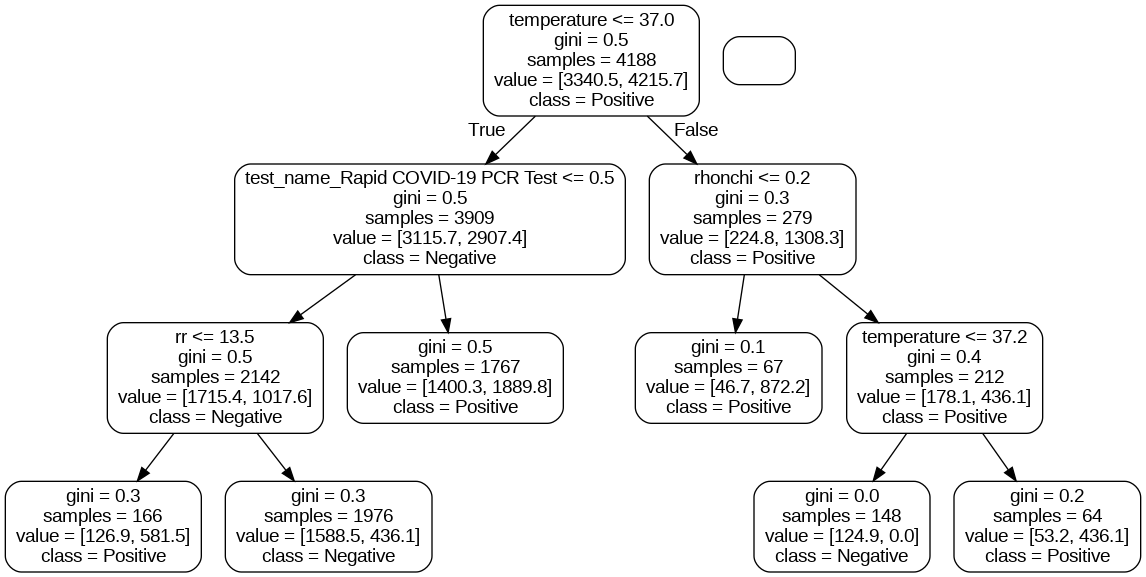

In [ ]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot


# Let's visualize some decision trees from our forest (from the last cross-val split)
number_of_trees_to_plot = 4

for i in range(number_of_trees_to_plot):
  tree_ind = np.random.randint(low=0,high=rf_params["n_estimators"]-1)
  tree_to_plot = classifier.estimators_[tree_ind]
  export_graphviz(tree_to_plot, out_file = 'tree.dot', feature_names = features, class_names=["Negative","Positive"],rounded = True, precision = 1)
  # Use dot file to create a graph
  (graph, ) = pydot.graph_from_dot_file('tree.dot')
  # Write graph to a png file
  display(Image(graph.create_png()))

Another way using the train test split 80-20%

In [ ]:
train, test, train_labels, test_labels = train_test_split(dataset,
                                          labels,
                                          stratify = labels,
                                          test_size = 0.2,
                                          random_state = RSEED)

In [ ]:
# Create the model
model = RandomForestClassifier(**rf_params)

In [ ]:
# Fit on training data
model.fit(train, train_labels)
#model = rf_random.best_estimator_
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)

print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [ ]:
  # Training predictions
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

In [ ]:
# This funcion plot ROC curve for train and test
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare train and test model performance.
    Computes statistics and shows ROC curve."""
    results = {}
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)

    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 3)} Train: {round(train_results[metric], 3)}')

    # Calculate false positive rates and true positive rates
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)
    model_train_fpr, model_train_tpr, _ = roc_curve(train_labels, train_probs)

    plt.figure(figsize = (20, 10))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(model_train_fpr, model_train_tpr, color=train_color, lw=4, label = 'model - train, AUC = '+np.array2string(round(train_results['roc'],2),precision=2,floatmode='fixed'))
    plt.plot(model_fpr, model_tpr, color=test_color, lw=4, label = 'model - test,  AUC = '+np.array2string(round(results['roc'],2),precision=2,floatmode='fixed'))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color=chance_color, label='Chance')


    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate');
    plt.title('Receiver Operating Characteristic, n_train = %0.0f, n_test = %0.0f' % (len(train_predictions), len(predictions)));
    plt.show();